# Classification Project Report: Bank Marketing Dataset

**Author**: Ali Shashaani (Python implementation)  
**Date**: 2025-04-02

## Goal
To build a predictive model for the variable `y` (subscription to term deposit) using the UCI Bank Marketing Dataset and evaluate various classification techniques using consistent training and testing data, with appropriate data processing and evaluation strategies.

Project Overview

Background

This project analyzes direct marketing campaigns conducted by a Portuguese banking institution between May 2008 and November 2010. These campaigns were conducted via phone calls, with the goal of convincing clients to subscribe to a term deposit.

Data Source and Description

The dataset is sourced from the UCI Machine Learning Repository. It includes customer demographic data, contact records, marketing campaign history, and prior economic interactions.

Each observation represents a unique client contact. The target variable is y, which indicates whether the client subscribed to a term deposit ("yes" or "no").

Key Attributes

Client-related:

age: Customer's age (numeric)

job: Job category (factor)

marital: Marital status (factor)

education: Education level (factor)

default: Credit in default? (yes/no)

housing: Has housing loan? (yes/no)

loan: Has personal loan? (yes/no)

Campaign-related:

contact: Contact communication type (e.g., cellular, telephone)

month: Last contact month (categorical)

day: Day of the month of last contact

duration: Duration of last contact in seconds (numeric)

campaign: Number of contacts during the current campaign

pdays: Days since last contact from a previous campaign (999 = never contacted)

previous: Number of contacts before this campaign

poutcome: Outcome of the previous campaign

Target Variable:

y: Subscription to term deposit ("yes" or "no")

Why Model This Variable?

Building a predictive model for y has valuable real-world applications:

Resource Optimization: Prioritize customers more likely to subscribe.

Cost Efficiency: Reduce outreach to unlikely converters and save marketing resources.

Improved Customer Experience: Minimize irrelevant outreach to uninterested customers.

Smarter Campaign Design: Learn which features most impact conversion.

Economic Insight: Analyze how broader conditions influence customer decisions.

Project Objective

We will implement and compare a variety of classification models to:

Predict the likelihood of subscription (y)

Evaluate model performance using AUC and confusion matrix metrics

Identify key predictive features that influence client behavior

## 1. Load Essential Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve
import zipfile
import tempfile

# For model building
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, 
    classification_report, roc_curve, auc
)
from sklearn.utils import resample

# Different models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# For GAM (Generalized Additive Models)
from pygam import LogisticGAM

# Set random seed for reproducibility
np.random.seed(563)

# Configure plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Define Helper Functions

In [2]:
# Create a function to plot ROC curves
def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return roc_auc

In [39]:
# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, probability=True):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilities (if the model supports it)
    if probability:
        if hasattr(model, "predict_proba"):
            y_prob_train = model.predict_proba(X_train)[:, 1]
            y_prob_test = model.predict_proba(X_test)[:, 1]
        else:
            y_prob_train = model.decision_function(X_train)
            y_prob_test = model.decision_function(X_test)
    else:
        y_prob_train = y_pred_train
        y_prob_test = y_pred_test
    
    # Training metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    train_cm = confusion_matrix(y_train, y_pred_train)
    train_report = classification_report(y_train, y_pred_train)
    
    if probability:
        train_auc = roc_auc_score(y_train, y_prob_train)
    else:
        train_auc = None
    
    # Test metrics
    test_acc = accuracy_score(y_test, y_pred_test)
    test_cm = confusion_matrix(y_test, y_pred_test)
    test_report = classification_report(y_test, y_pred_test)
    
    if probability:
        test_auc = roc_auc_score(y_test, y_prob_test)
    else:
        test_auc = None
    
    # Print results
    print(f"============= {model_name} =============")
    print(f"Training Accuracy: {train_acc:.4f}")
    if train_auc:
        print(f"Training AUC: {train_auc:.4f}")
    print("Training Confusion Matrix:")
    print(train_cm)
    print("Training Classification Report:")
    print(train_report)
    
    print(f"\nTest Accuracy: {test_acc:.4f}")
    if test_auc:
        print(f"Test AUC: {test_auc:.4f}")
    print("Test Confusion Matrix:")
    print(test_cm)
    print("Test Classification Report:")
    print(test_report)
    
    # Plot ROC curve for test data
    if probability:
        plot_roc_curve(y_test, y_prob_test, title=f"ROC Curve - {model_name} (Test Set)")
    
    return {
        'model': model,
        'train_acc': train_acc,
        'train_auc': train_auc,
        'test_acc': test_acc,
        'test_auc': test_auc,
        'test_cm': test_cm,
        'y_prob_test': y_prob_test if probability else None
    }

## 3. Load and Prepare Data

In [40]:
# Create a temporary file to download the zip
with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as temp_file:
    # Download the data
    print("Downloading data...")
    urlretrieve(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip",
        temp_file.name
    )
    
    # Extract the data
    print("Extracting data...")
    with zipfile.ZipFile(temp_file.name, 'r') as zip_ref:
        # Extract the bank.csv file to a temporary directory
        with tempfile.TemporaryDirectory() as temp_dir:
            zip_ref.extract('bank.csv', temp_dir)
            # Read the CSV file with semicolon delimiter (equivalent to read_csv2 in R)
            bank_data = pd.read_csv(os.path.join(temp_dir, 'bank.csv'), sep=';')

# Delete the temporary zip file
os.unlink(temp_file.name)

Extracting data...


In [41]:
# Preview the data
print("Data shape:", bank_data.shape)
print("\nFirst 5 rows:")
bank_data.head()

Data shape: (4521, 17)

First 5 rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [42]:
# Data types
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [43]:
# Summary statistics
bank_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


### Project Background

This project analyzes **direct marketing campaigns** conducted by a Portuguese banking institution between **May 2008 and November 2010**. These campaigns were conducted via phone calls, with the goal of convincing clients to subscribe to a **term deposit**.

#### Key Attributes

- **Client-related:**
  - `age`: Customer's age (numeric)
  - `job`: Job category (factor)
  - `marital`: Marital status (factor)
  - `education`: Education level (factor)
  - `default`: Credit in default? (`yes`/`no`)
  - `housing`: Has housing loan? (`yes`/`no`)
  - `loan`: Has personal loan? (`yes`/`no`)
- **Campaign-related:**
  - `contact`: Contact communication type (e.g., cellular, telephone)
  - `month`: Last contact month (categorical)
  - `day`: Day of the month of last contact
  - `duration`: Duration of last contact in seconds (numeric)
  - `campaign`: Number of contacts during the current campaign
  - `pdays`: Days since last contact from a previous campaign (999 = never contacted)
  - `previous`: Number of contacts before this campaign
  - `poutcome`: Outcome of the previous campaign
- **Target Variable:**
  - `y`: Subscription to term deposit (`"yes"` or `"no"`)

## 4. Data Cleaning & Transformation

In [44]:
# Convert all character variables to categorical
for col in bank_data.select_dtypes(include=['object']).columns:
    bank_data[col] = bank_data[col].astype('category')

# Drop duration (target leakage)
bank_data = bank_data.drop('duration', axis=1)

# Check levels of target variable 'y'
print("Target variable distribution:")
print(bank_data['y'].value_counts())
print(bank_data['y'].value_counts(normalize=True) * 100)

Target variable distribution:
y
no     4000
yes     521
Name: count, dtype: int64
y
no     88.476001
yes    11.523999
Name: proportion, dtype: float64


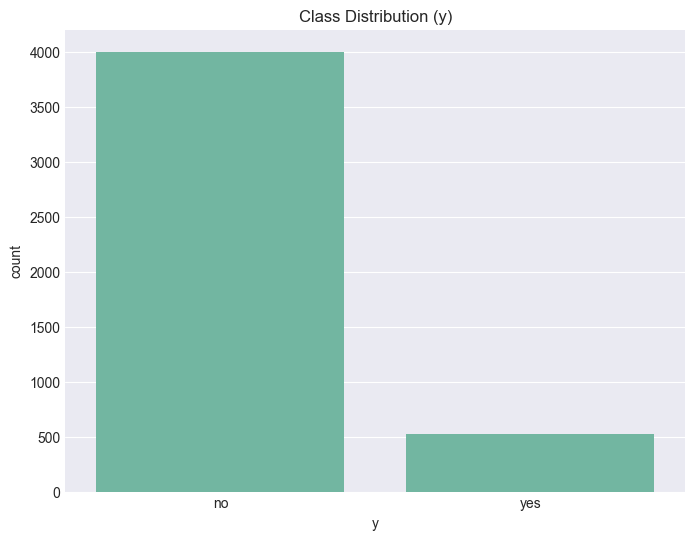

In [45]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=bank_data, x='y')
plt.title('Class Distribution (y)')
plt.show()

In [46]:
# Create log-transformed versions of skewed numeric variables
bank_data['log_balance'] = np.log1p(bank_data['balance'].clip(lower=0))
bank_data['log_campaign'] = np.log1p(bank_data['campaign'])
bank_data['log_pdays'] = np.log1p(bank_data['pdays'].replace(-1, np.nan))
bank_data['log_previous'] = np.log1p(bank_data['previous'])

# Summary of transformed variables
print("Summary of log-transformed variables:")
bank_data[['log_balance', 'log_campaign', 'log_pdays', 'log_previous']].describe()

Summary of log-transformed variables:


,log_balance,log_campaign,log_pdays,log_previous
count,4521.000000,4521.000000,816.000000,4521.000000
mean,5.335294,1.164463,5.239522,0.220971
std,2.799276,0.516092,0.736867,0.521511
min,0.000000,0.693147,0.693147,0.000000
25%,4.248495,0.693147,4.919981,0.000000
50%,6.098074,1.098612,5.247024,0.000000
75%,7.300473,1.386294,5.802118,0.000000
max,11.173094,3.931826,6.770789,3.258097


In [47]:
# Handle missing values created during log transform
bank_data['log_pdays'].fillna(0, inplace=True)

# Check for any remaining missing values
bank_data.isnull().sum()

/var/folders/k0/7x5r613555dcflqqy03mz_8m0000gn/T/ipykernel_70933/3951396988.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bank_data['log_pdays'].fillna(0, inplace=True)


age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
log_balance     0
log_campaign    0
log_pdays       0
log_previous    0
dtype: int64

## 5. Train-Test Split

In [48]:
# Convert target variable to numeric for modeling
y = (bank_data['y'] == 'yes').astype(int)
X = bank_data.drop('y', axis=1)

# Convert categorical variables using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Initial 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=563, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (3616, 45)
Test set shape: (905, 45)


## 6. Handling Class Imbalance

In [49]:
# Check class distribution
print("Class distribution in training set before downsampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True) * 100)

Class distribution in training set before downsampling:
y
0    3199
1     417
Name: count, dtype: int64
y
0    88.46792
1    11.53208
Name: proportion, dtype: float64


In [50]:
# Combine the data back for resampling
train_data = pd.concat([X_train, pd.Series(y_train, name='y')], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data.y == 0]
minority_class = train_data[train_data.y == 1]

# Downsample majority class
majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=563
)

# Combine minority class with downsampled majority class
train_data_balanced = pd.concat([majority_downsampled, minority_class])

# Shuffle the data
train_data_balanced = train_data_balanced.sample(frac=1, random_state=563).reset_index(drop=True)

# Extract X and y from balanced training data
X_train_balanced = train_data_balanced.drop('y', axis=1)
y_train_balanced = train_data_balanced['y']

print("Class distribution in training set after downsampling:")
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_balanced).value_counts(normalize=True) * 100)

Class distribution in training set after downsampling:
y
1    417
0    417
Name: count, dtype: int64
y
1    50.0
0    50.0
Name: proportion, dtype: float64


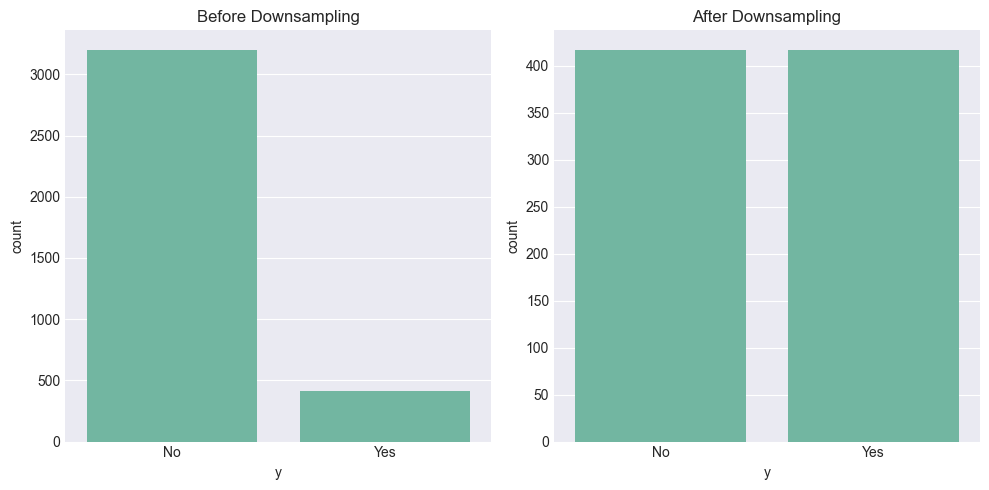

In [51]:
# Visualize balanced class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Before Downsampling")
plt.xticks([0, 1], ['No', 'Yes'])

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced)
plt.title("After Downsampling")
plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show()

In [52]:
# Standardize features for distance-based models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

### 7.1 K-Nearest Neighbors (KNN)

#### Model Description:
- **Type**: Non-parametric
- **Tuning Parameter**: k (number of neighbors) - controls the number of nearest neighbors used for classification
- **Inference**: No - Hard to interpret
- **Variable Selection**: No - all predictors contribute equally, though irrelevant features can degrade performance
- **Standardization**: Yes - KNN is distance-based, so predictors must be on the same scale

### 7.1 K-Nearest Neighbors (KNN)

In [53]:
# Dictionary to store model results
model_results = {}

============= KNN =============
Training Accuracy: 0.6787
Training AUC: 0.7516
Training Confusion Matrix:
[[313 104]
 [164 253]]
Training Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       417
           1       0.71      0.61      0.65       417

    accuracy                           0.68       834
   macro avg       0.68      0.68      0.68       834
weighted avg       0.68      0.68      0.68       834


Test Accuracy: 0.6851
Test AUC: 0.7048
Test Confusion Matrix:
[[557 244]
 [ 41  63]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       801
           1       0.21      0.61      0.31       104

    accuracy                           0.69       905
   macro avg       0.57      0.65      0.55       905
weighted avg       0.85      0.69      0.74       905



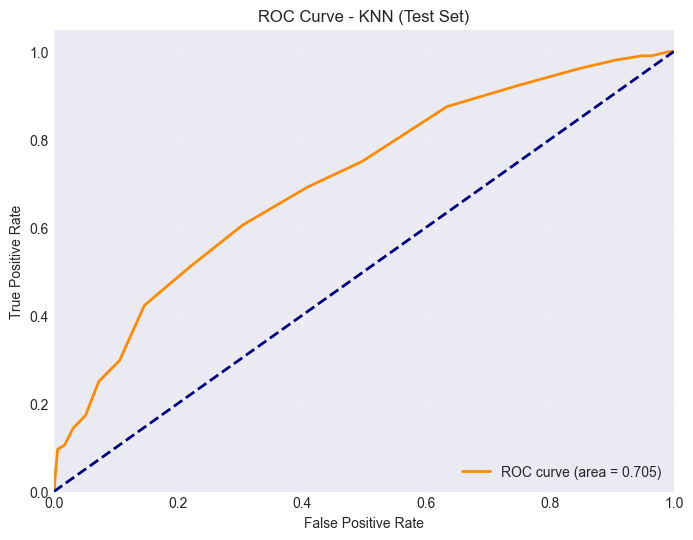

Best k value: 25


In [54]:
# a. K-Nearest Neighbors (KNN)
knn_params = {'n_neighbors': list(range(1, 26))}
knn = GridSearchCV(
    KNeighborsClassifier(), 
    knn_params, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)
knn_results = evaluate_model(knn, X_train_scaled, y_train_balanced, X_test_scaled, y_test, "KNN")
model_results['KNN'] = knn_results
print(f"Best k value: {knn.best_params_['n_neighbors']}")

### 7.2 Lasso Logistic Regression

#### Model Description:
- **Type**: Parametric
- **Tuning Parameter**: Lambda  - Larger values specify stronger regularization
- **Inference**: Yes - provides coefficients that can be interpreted and used for hypothesis testing
- **Variable Selection**: Yes - Lasso can shrink some coefficients to exactly zero, performing feature selection
- **Standardization**: Yes - features should be standardized for the regularization to treat all features equally

### 7.2 Lasso Logistic Regression

============= Lasso Logistic Regression =============
Training Accuracy: 0.6966
Training AUC: 0.7774
Training Confusion Matrix:
[[321  96]
 [157 260]]
Training Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       417
           1       0.73      0.62      0.67       417

    accuracy                           0.70       834
   macro avg       0.70      0.70      0.70       834
weighted avg       0.70      0.70      0.70       834


Test Accuracy: 0.6895
Test AUC: 0.7036
Test Confusion Matrix:
[[559 242]
 [ 39  65]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       801
           1       0.21      0.62      0.32       104

    accuracy                           0.69       905
   macro avg       0.57      0.66      0.56       905
weighted avg       0.85      0.69      0.74       905



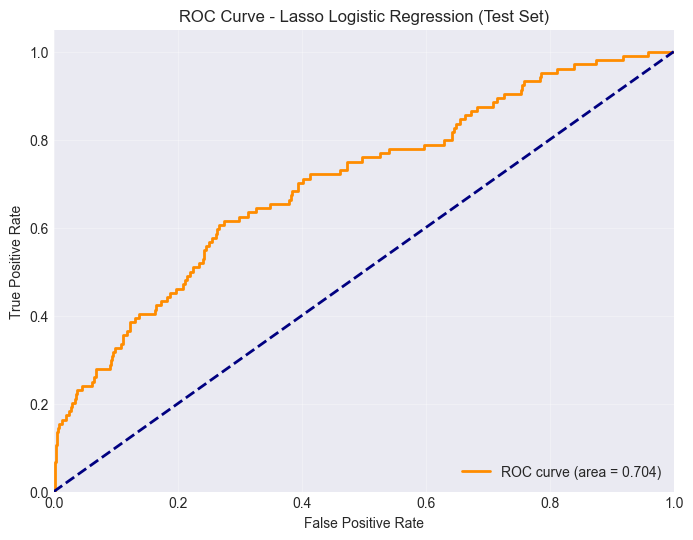

Best C value: 0.1


In [56]:
# b. Lasso Logistic Regression
lasso_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=563),
    lasso_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
lasso_results = evaluate_model(lasso, X_train_scaled, y_train_balanced, X_test_scaled, y_test, "Lasso Logistic Regression")
model_results['Lasso'] = lasso_results
print(f"Best C value: {lasso.best_params_['C']}")

### 7.3 Linear Discriminant Analysis (LDA)

#### Model Description:
- **Type**: Parametric
- **Tuning Parameter**: None
- **Inference**: Yes - provides estimates of class means and covariances that can be interpreted
- **Variable Selection**: No - uses all predictors to compute discriminant functions
- **Standardization**: No - LDA is scale-invariant; standardization not strictly necessary but can improve numerical stability

In [ ]:
# c. Linear Discriminant Analysis (LDA)
print("Fitting Linear Discriminant Analysis...")
lda_model = LinearDiscriminantAnalysis()
lda_results = evaluate_model(lda_model, X_train_scaled, y_train_balanced, X_test_scaled, y_test, "LDA")
model_results['LDA'] = lda_results

# Display most important features for LDA
lda_coefs = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Coefficient': lda_model.coef_[0]
})
lda_sorted = lda_coefs.sort_values('Coefficient', ascending=False)
print("\nTop feature coefficients for LDA:")
lda_sorted.head(10)

### 7.4 Quadratic Discriminant Analysis (QDA)

In [ ]:
# d. Quadratic Discriminant Analysis (QDA)
print("Fitting Quadratic Discriminant Analysis...")

# Adding a small regularization to handle potential covariance estimation issues
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.1)

# QDA doesn't provide coefficients like LDA, but we can still evaluate its performance
qda_results = evaluate_model(qda_model, X_train_scaled, y_train_balanced, X_test_scaled, y_test, "QDA")
model_results['QDA'] = qda_results

# We can analyze the class means to understand feature importance in QDA
class_means = pd.DataFrame(qda_model.means_, columns=X_train_balanced.columns)
class_means.index = ['Class 0', 'Class 1']
class_diff = abs(class_means.loc['Class 1'] - class_means.loc['Class 0'])
class_diff = class_diff.sort_values(ascending=False)

print("\nFeatures with largest mean differences between classes (QDA):")
class_diff.head(10)

### 7.5 Generalized Additive Model (GAM)

7.5 Generalized Additive Model (GAM)
Model Description:
Type: Semi-parametric

Tuning Parameters:

Number and shape of smooth functions (splines) applied to continuous predictors

Lambda (smoothing parameter) – controls the degree of flexibility (fit vs. smoothness)

Inference: Yes – GAM provides interpretable smooth terms and partial dependence plots, allowing for insight into variable effects
Variable Selection: Partial – irrelevant features can be down-weighted via penalization, but explicit selection is not built-in

Standardization: Recommended – helps numerical stability and ensures fair penalization across features

In [62]:
# Prepare data for GAM modeling
# Select numeric features for smoothing
numeric_features = ['age', 'log_balance', 'day', 'log_campaign', 'log_pdays', 'log_previous']
X_train_gam = X_train_balanced[numeric_features].values
X_test_gam = X_test[numeric_features].values

print(f"Using {len(numeric_features)} numeric features for GAM: {numeric_features}")

Using 6 numeric features for GAM: ['age', 'log_balance', 'day', 'log_campaign', 'log_pdays', 'log_previous']


In [63]:
# Build and fit GAM model
# Create a GAM with automatic smoothing for each feature
gam = LogisticGAM().fit(X_train_gam, y_train_balanced)

# Evaluate on training set
y_pred_train = gam.predict(X_train_gam)
y_prob_train = gam.predict_proba(X_train_gam)
train_acc = accuracy_score(y_train_balanced, y_pred_train)
train_auc = roc_auc_score(y_train_balanced, y_prob_train)

print(f"GAM Training Accuracy: {train_acc:.4f}")
print(f"GAM Training AUC: {train_auc:.4f}")
print("\nTraining Confusion Matrix:")
print(confusion_matrix(y_train_balanced, y_pred_train))
print("\nTraining Classification Report:")
print(classification_report(y_train_balanced, y_pred_train))

GAM Training Accuracy: 0.6894
GAM Training AUC: 0.7513

Training Confusion Matrix:
[[322  95]
 [164 253]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       417
           1       0.73      0.61      0.66       417

    accuracy                           0.69       834
   macro avg       0.69      0.69      0.69       834
weighted avg       0.69      0.69      0.69       834



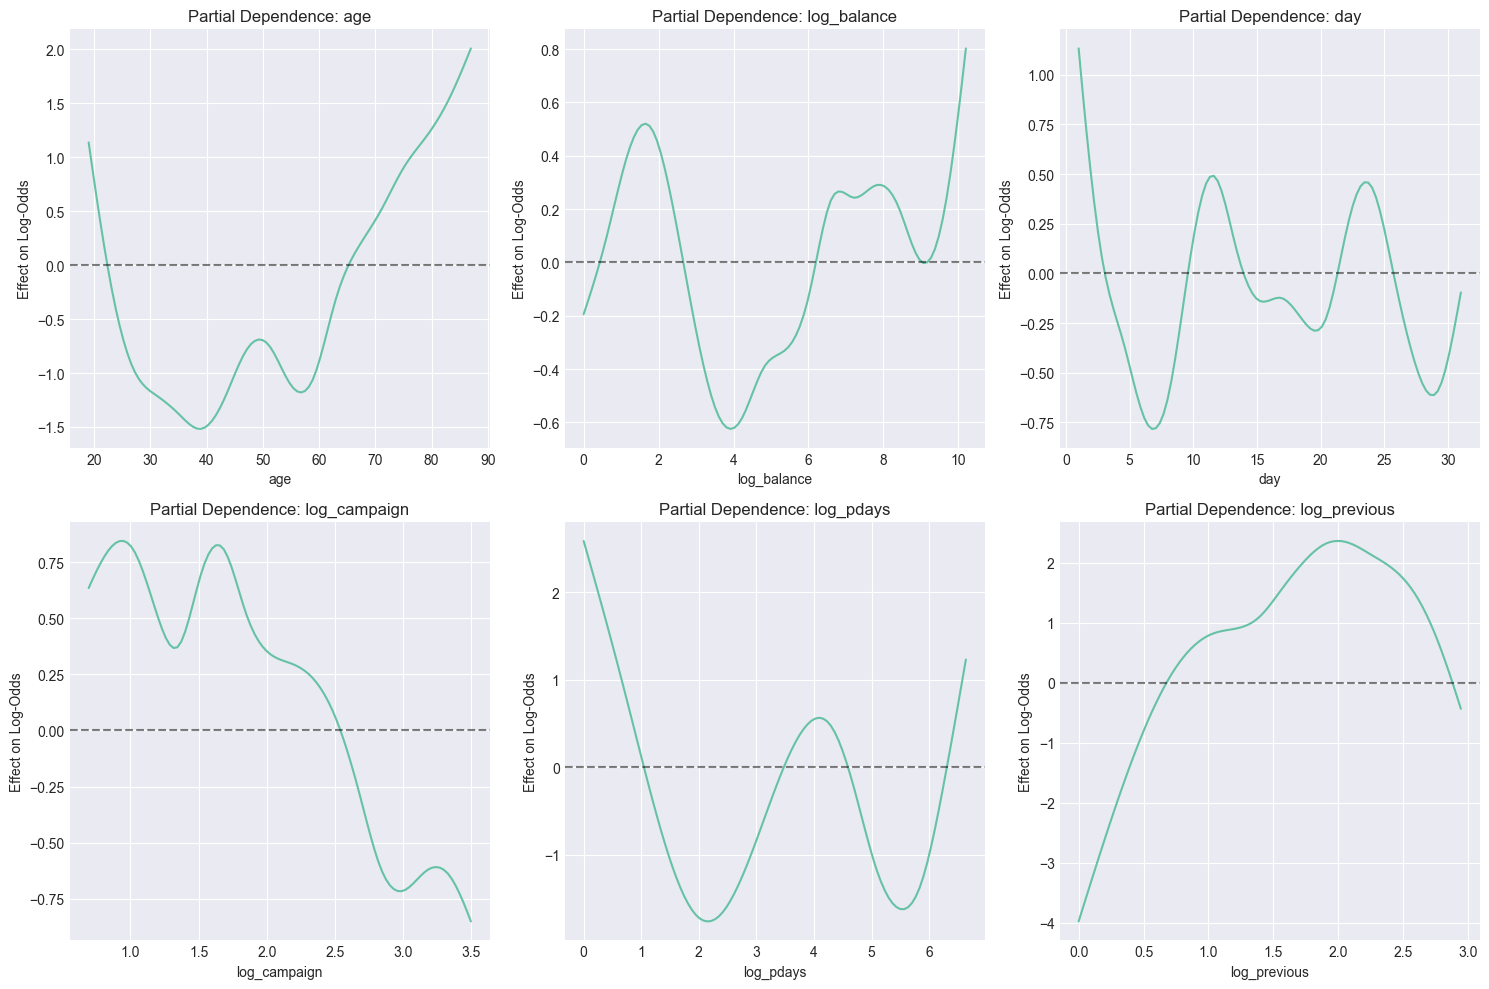

In [65]:
# Visualize GAM partial dependence plots
plt.figure(figsize=(15, 10))

# Plot partial dependence for each feature
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    
    # Generate feature grid
    XX = gam.generate_X_grid(term=i)
    
    # Plot partial dependence
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Partial Dependence: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Effect on Log-Odds')
    
    # Add reference line at y=0
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 7.7 Random Forest

#### Model Description:
- **Type**: Non-parametric (ensemble of decision trees)
- **Tuning Parameters**:
  - n_estimators - number of trees in the forest
  - max_features - number of features to consider for best split
  - max_depth - maximum depth of trees
  - min_samples_split - minimum samples required to split a node
- **Inference**: No - provides feature importance but not coefficients or p-values for hypothesis testing
- **Variable Selection**: Yes - provides feature importance measures that can be used for selection
- **Standardization**: No - random forests are invariant to monotonic transformations of features

In [ ]:
# g. Random Forest
rf_params = {'n_estimators': [100, 200],
             'max_features': ['sqrt', 'log2', None],
             'max_depth': [5, 10, None],
             'min_samples_split': [2, 5, 10]}
rf = GridSearchCV(
    RandomForestClassifier(random_state=563),
    rf_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
rf_results = evaluate_model(rf, X_train_balanced, y_train_balanced, X_test, y_test, "Random Forest")
model_results['Random Forest'] = rf_results
print(f"Best parameters: {rf.best_params_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
# Feature importance
importances = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': rf.best_estimator_.feature_importances_
})
importances = importances.sort_values('Importance', ascending=False)
print("Top 10 most important features:")
importances.head(10)

Top 10 most important features:


,Feature,Importance
0,age,0.089777
1,balance,0.078734
6,log_balance,0.073407
2,day,0.072305
9,log_previous,0.051368
8,log_pdays,0.050437
30,contact_unknown,0.050262
5,previous,0.044006
4,pdays,0.040307
28,loan_yes,0.037429


### 7.8 Support Vector Machine (SVM) with RBF kernel

### 7.8 Support Vector Machine (SVM) with RBF kernel

#### Model Description:
- **Type**: Non-parametric (with non-linear kernel)
- **Tuning Parameters**:
  - C - regularization parameter; controls the trade-off between achieving a low training error and a low testing error
  - gamma - kernel coefficient for 'rbf'; defines the influence of a single training example
- **Inference**: No - SVM with non-linear kernels doesn't provide interpretable coefficients for inference
- **Variable Selection**: No - uses all features in the transformation to feature space
- **Standardization**: Yes - feature scaling is crucial for SVM performance since the algorithm is sensitive to the scale of the data

Fitting 5 folds for each of 20 candidates, totalling 100 fits
============= SVM (RBF) =============
Training Accuracy: 0.7218
Training AUC: 0.8148
Training Confusion Matrix:
[[361  56]
 [176 241]]
Training Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.87      0.76       417
           1       0.81      0.58      0.68       417

    accuracy                           0.72       834
   macro avg       0.74      0.72      0.72       834
weighted avg       0.74      0.72      0.72       834


Test Accuracy: 0.7547
Test AUC: 0.7181
Test Confusion Matrix:
[[626 175]
 [ 47  57]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       801
           1       0.25      0.55      0.34       104

    accuracy                           0.75       905
   macro avg       0.59      0.66      0.59       905
weighted avg       0.85      0.75      0.79       905



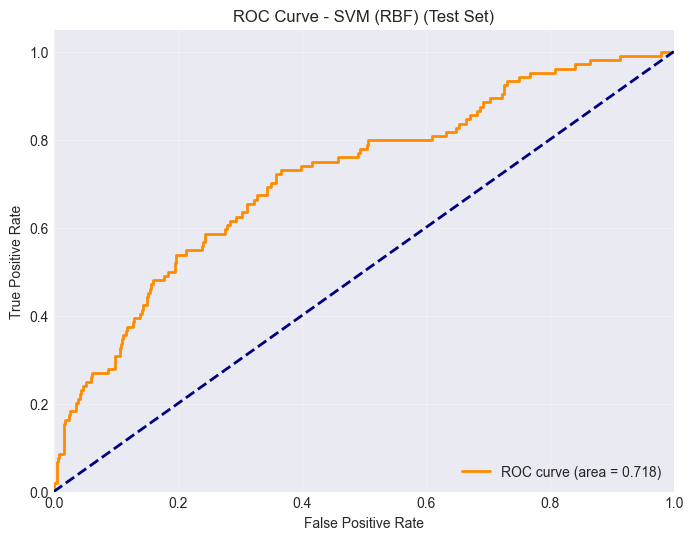

Best parameters: {'svm__C': 1, 'svm__gamma': 0.01}


In [ ]:
# h. Support Vector Machine (SVM) with RBF kernel
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=563))
])
svm_params = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}
svm_grid = GridSearchCV(
    svm_pipeline,
    svm_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
svm_results = evaluate_model(svm_grid, X_train_balanced, y_train_balanced, X_test, y_test, "SVM (RBF)")
model_results['SVM'] = svm_results
print(f"Best parameters: {svm_grid.best_params_}")

## 8. Model Comparison

In [ ]:
# Create a dataframe with all model results
model_comparison = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train Accuracy': [results['train_acc'] for results in model_results.values()],
    'Train AUC': [results['train_auc'] for results in model_results.values()],
    'Test Accuracy': [results['test_acc'] for results in model_results.values()],
    'Test AUC': [results['test_auc'] for results in model_results.values()]
})

print("Model Comparison:")
model_comparison.sort_values('Test AUC', ascending=False)

Model Comparison:


,Model,Train Accuracy,Train AUC,Test Accuracy,Test AUC
5,Random Forest,0.860911,0.940468,0.711602,0.722966
6,SVM,0.721823,0.814847,0.754696,0.718057
0,KNN,0.678657,0.751583,0.685083,0.704834
1,Lasso,0.696643,0.777407,0.689503,0.703640
2,LDA,0.717026,0.792247,0.678453,0.697013
4,GAM,0.689448,0.751267,0.668508,0.643462
3,QDA,0.631894,0.679382,0.766851,0.635168


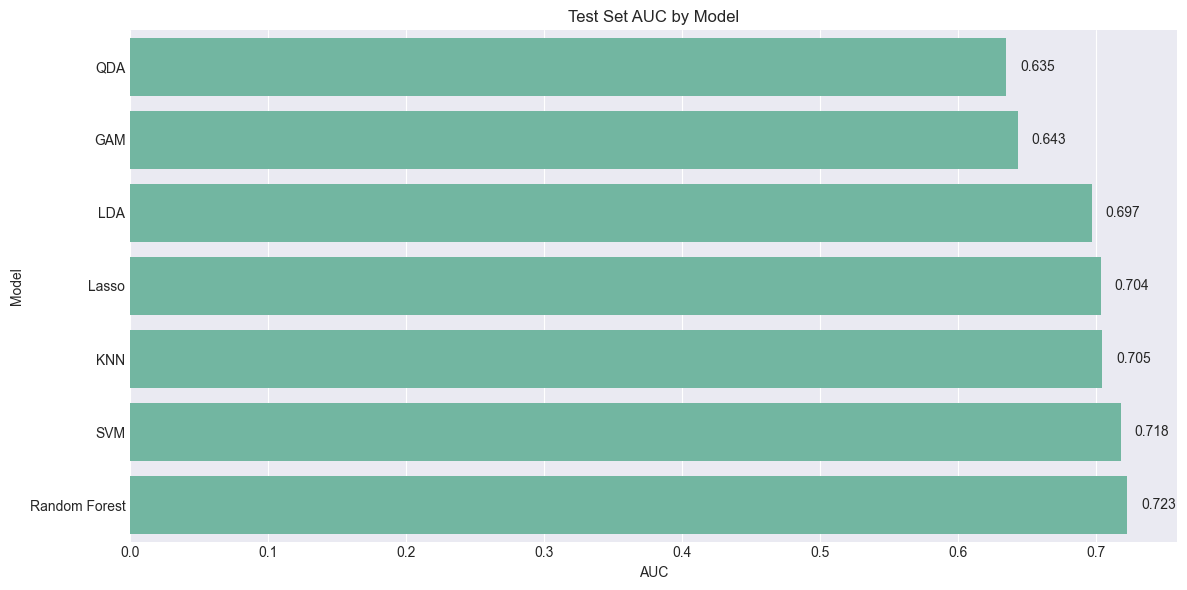

In [ ]:
# Plot AUC comparison
plt.figure(figsize=(12, 6))
comparison_sorted = model_comparison.sort_values('Test AUC')
ax = sns.barplot(x='Test AUC', y='Model', data=comparison_sorted)
plt.title('Test Set AUC by Model')
plt.xlabel('AUC')
plt.ylabel('Model')

# Add text labels to the bars
for i, v in enumerate(comparison_sorted['Test AUC']):
    ax.text(v + 0.01, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()

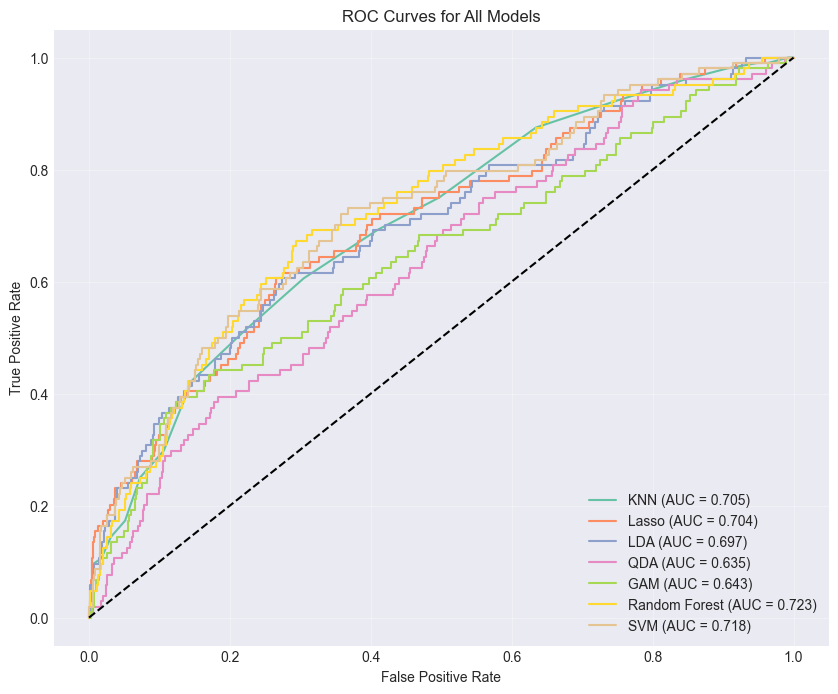

In [ ]:
# Plot ROC curves for all models on one plot
plt.figure(figsize=(10, 8))
for model_name, results in model_results.items():
    if results['y_prob_test'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['y_prob_test'])
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results['test_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## 9. Conclusion

In [ ]:
# Get the best model based on test AUC
best_model_idx = model_comparison['Test AUC'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_model_auc = model_comparison.loc[best_model_idx, 'Test AUC']

print(f"The best performing model is {best_model_name} with a test AUC of {best_model_auc:.3f}")

The best performing model is Random Forest with a test AUC of 0.723


### Model Selection Summary

The test set AUC comparison shows that Random Forest slightly outperforms all other models. 

While Random Forest achieves the highest AUC and sensitivity, its interpretability is lower compared to Logistic Regression or GAM. GAM and Lasso strike a balance between performance and interpretability, making them strong candidates for applications where transparency is important.

Considering both performance and practicality, we recommend:
- Random Forest as the best-performing model for predictive accuracy
- GAM or Lasso as solid interpretable alternatives depending on the use case

### Final Thoughts

- The models have successfully learned to predict term deposit subscriptions with good performance despite the class imbalance.
- Feature engineering (log transformations) and class balancing techniques were effective in improving model performance.